<a href="https://colab.research.google.com/github/virf96/Chat-Bot/blob/master/DatosFaltantes_SustitucionModa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sustitución por moda | categoría más frecuente

Los métodos de imputación consisten en estimar los valores faltantes en base a los valores existentes de una variable. El objetivo de cualquier método de imputación es producir un **conjunto completo** de datos que pueda ser utilizado por un algoritmo de aprendizaje de máquina (machine learning). 

En sustitución por la moda, asignamos la categoría más frecuente o la moda, a los valores nulos.

### Cuáles variables se pueden sustituir por la moda/categoría más frecuente?

A pesar que la moda/categoría más frecuente puede ser calculada para variables numéricas y categóricas, en la práctica, solamente usamos esta técnica en variables categóricas. 
En variables numéricas, la media o la mediana suelen ser mejores parámetros para representar la distribución.

### Condiciones

- Los datos faltan completamente al azar (MCAR)
- Lo más probable es que las observaciones ausentes tengan valores similares a los de la mayoría de las observaciones en la variable (o sea la moda o categoría más frecuente)

### Ventajas

- Fácil de implementar
- Forma rápida de obtener conjuntos completos de datos
- Puede ser integrado en producción (durante el despliegue del modelo)

### Limitaciones

- Distorsión de la relación entre la etiquete más frecuente con las demás variables dentro del conjunto de datos.
- Puede llevar a la sobre-representación de la etiqueta más frecuente si hay muchos valores nulos

### Cuándo usar la sustitución por la moda/categoría más frecuente?

- Los datos faltan completamente al azar (MCAR)
- No más del 5% de las observaciones presentan valores nulos


## En este demo:

Vamos a aprender cómo implementar la sustitución por la moda usando pandas y los datos Ames House Price 



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### House Price dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# carguemos datos con unas columnas

# estas son las columnas categóricas y la variable target SalePrice (precio de venta)
cols_to_use = ['BsmtQual', 'FireplaceQu', 'SalePrice']

data = pd.read_csv('/content/drive/My Drive/datasets/houseprice.csv', usecols=cols_to_use)
data.head()

,BsmtQual,FireplaceQu,SalePrice
0,Gd,NaN,208500
1,Gd,TA,181500
2,Gd,TA,223500
3,TA,Gd,140000
4,Gd,TA,250000


In [5]:
# evaluemos el porcentaje de valores nulos por cada una de las variables
#Notamos 2.5% de missing values en "BsmtQual"
#Notamos 47% de missing values en "FireplaceQu"
data.isnull().mean()

BsmtQual       0.025342
FireplaceQu    0.472603
SalePrice      0.000000
dtype: float64

La variable BsmtQual contiene solo unas pocas observaciones con valores nulos (2.5%), por lo tanto, reemplazar estas observaciones con el valor de la categoría más frecuente es una buena idea.

Por otra parte, la variable FireplaceQu, tiene valores ausentes en casi la mitad de las observaciones. Por lo tanto, si los reemplazamos con la categoría más frecuente, lo más probable es que distorsionemos la relación entre la categoría más frecuente con la variable target SalePrice (precio de venta). 

Adicionalmente, si muchas observaciones están ausentes en FireplaceQu, puede que exista una razón de  por la que estén faltando, por lo tanto, el método de sustitución que explicamos en el siguiente notebooks, seria mas apropiado.


### Para tener en cuenta

Los parámetros para la sustitución o imputación se deben aprender sobre el set de datos de entrenamiento, usado para entrenar el modelo. Luego estos mismos parámetros se utilizan para imputar valores nulos en el set de prueba. Y esto es para evitar sobre-ajustes. En este caso, la categoría más frecuente, debe calcularse sobre el set de entrenamiento


In [27]:
# separar datos en segmentos entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['SalePrice'], # target
    test_size=0.3, # porcentaje de obs en test set
    random_state=0) # semilla para reproducibilidad

X_train.shape, X_test.shape

((1022, 3), (438, 3))

#### BsmtQual

In [28]:
# % de valores ausentes
#El porcentaje de valores nulos ha bajado dado que solo tenemos el 70% de la base original en el train set
X_train['BsmtQual'].isnull().mean()

0.023483365949119372

Text(0, 0.5, 'Number of houses')

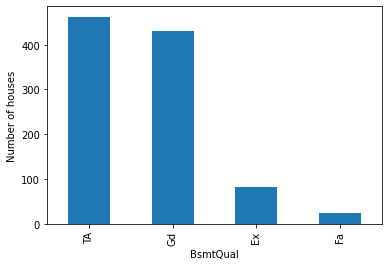

In [29]:
# exploremos el número de observaciones por categoría en "BsmtQual"

# usamos esta línea de código en la sección 3 “características de las variables”

# value_counts() retorna el número de observaciones por categoría de la variable

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses')

In [30]:
# categoría más frecuente para BsmtQual

X_train['BsmtQual'].mode()

0    TA
dtype: object

Text(0.5, 1.0, 'BsmtQual')

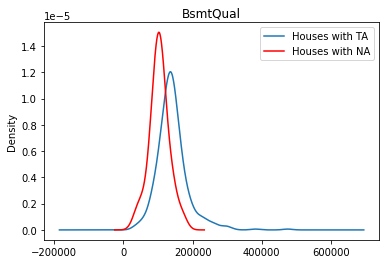

In [31]:
# grafiquemos las distribuciones de la variable target para las casas que: 

# tienen la categoría más frecuente o
# para aquellas que tienen datos ausentes

fig = plt.figure()
ax = fig.add_subplot(111)

# selección y gráfica de las casas con la etiqueta más frecuente
X_train[X_train['BsmtQual']=='TA']['SalePrice'].plot(kind='kde', ax=ax)

# selección y gráfica de las casas con valores ausentes
X_train[X_train['BsmtQual'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with NA']
ax.legend(lines, labels, loc='best')

# título
plt.title('BsmtQual')

La gráfica anterior indica que las casas con datos ausentes cuestan en promedio mucho menos que aquellas con la etiqueta TA. Por lo tanto, si reemplazamos los valores ausentes con TA, podríamos afectar la distribución general, si hay una proporción grande de observaciones con valores nulos.

In [32]:
# guardemos la distribución original de SalePrice para la
# categoría más frecuente ( la usaremos más adelante)

# el uso de 'tmp' como nombre de las variables temporales
# es una práctica bastante común

tmp = X_train[X_train['BsmtQual']=='TA']['SalePrice']

In [33]:
# reemplacemos NA en los sets de prueba y entrenamiento

# usemos el método fillna() de pandas

# con el argumento inplace=True, indicándole a pandas
# que queremos reemplazar los valores en los datos

X_train['BsmtQual'].fillna('TA', inplace=True)
X_test['BsmtQual'].fillna('TA', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [34]:
# revisemos que los NA se han reemplazado 

X_train['BsmtQual'].isnull().sum()

0

Text(0, 0.5, 'Número de casas')

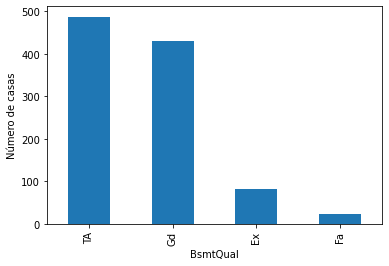

In [35]:
# evaluemos el efecto de este cambio en la distribución de las variables

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Número de casas')

De la gráfica anterior, podemos ver que ahora hay más casas con la etiqueta TA, que son las que antes tenían un valor nulo o NA. Sin embargo, también se puede observar que el cambio no es dramático; la gráfica se ve casi igual que antes de la sustitución.

Text(0.5, 1.0, 'BsmtQual')

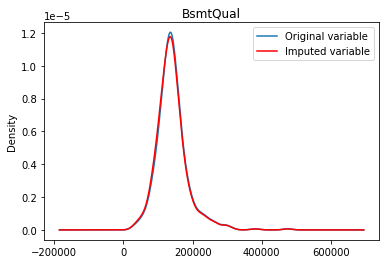

In [36]:
# grafiquemos la distribución del target (SalePrice - precio de venta)

# ha cambiado para la categoría más frecuente?
# veamos
fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original del SalePrice para casas con la categoría más frecuente
# recuerda que la guardamos unas celdas atrás en el notebook
tmp.plot(kind='kde', ax=ax)

# distribución de la variable después de la sustitución
X_train[X_train['BsmtQual'] == 'TA']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# leyenda
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

# título
plt.title('BsmtQual')

In [37]:
print('promedio de precios de la distribución original',tmp.mean())
print('promedio de precios de la distribución sustituida',X_train[X_train['BsmtQual'] == 'TA']['SalePrice'].mean())

promedio de precios de la distribución original 141808.65010799136
promedio de precios de la distribución sustituida 139915.3162217659


La distribución de los precios de las casas entre la variable original y sustituida son muy similares, porque el número de datos ausentes era pequeño. Esto era de esperarse.

Exploremos el efecto de la sustitución por la moda cuando el porcentaje de datos ausentes es alto.

#### FirePlaceQu

In [17]:
# recordemos el % de datos ausentes
X_train['FireplaceQu'].isnull().mean()

0.46771037181996084

Text(0, 0.5, 'Número de casas')

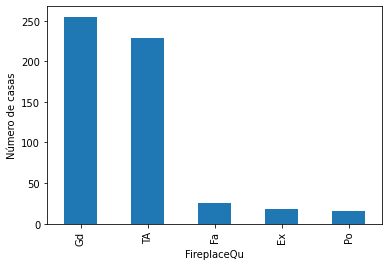

In [18]:
# exploremos el número de observaciones por categoría

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Número de casas')

In [19]:
# encontremos la categoría mas frecuente en la variable FirePlaceQu

X_train['FireplaceQu'].mode()

0    Gd
dtype: object

Text(0.5, 1.0, 'FirePlaceQu')

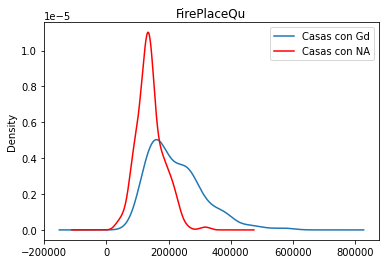

In [20]:
# grafiquemos la distribución del target (SalePrice - precio de venta)
# para las casas que tienen la categoría más frecuente y aquellas que 
# tienen datos ausentes


fig = plt.figure()
ax = fig.add_subplot(111)

# casas con la categoría más frecuente para FirePlaceQu
X_train[X_train['FireplaceQu']=='Gd']['SalePrice'].plot(kind='kde', ax=ax)

# casas con datos ausentes en FirePlaceQu
X_train[X_train['FireplaceQu'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# leyenda
lines, labels = ax.get_legend_handles_labels()
labels = ['Casas con Gd', 'Casas con NA']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu')

Las distribuciones son diferentes; las casas con datos ausentes cuestan menos en general que las casas con la etiquete Gd.

In [21]:
# Guardemos la distribuciones originales de SalePrice para
# las casas que tienen la etiquete Gd en FirePlaceQu.

tmp = X_train[X_train['FireplaceQu']=='Gd']['SalePrice']

In [22]:
# Reemplacemos los valores nulos NA con la etiqueta Gd en los sets de entrenamiento y prueba

X_train['FireplaceQu'].fillna('Gd', inplace=True)
X_test['FireplaceQu'].fillna('Gd', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Text(0, 0.5, 'Número de casas')

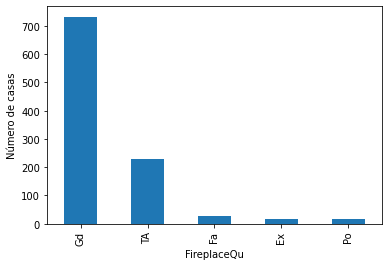

In [23]:
# exploremos el número de observaciones por categoría

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Número de casas')

En este caso vemos que hay una gran distorsión en la distribución original de la variable. Ahora hay muchas casas que tienen la etiqueta Gd, con respecto a las casas que tienen las otras categorías. Originalmente, la mitad de las observaciones en FirePlaceQu estaban ausentes. Ahora, todos los valores contienen Gd. Por eso es que vemos un gran incremento en Gd en la gráfica de barras.

Text(0.5, 1.0, 'FirePlaceQu')

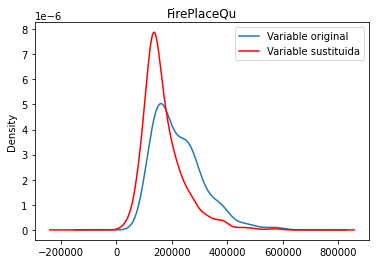

In [24]:
# grafiquemos las distribuciones del target para la variable original y
# la variable después de la sustitución

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original de la variable
# recuerda que la guardamos unas celdas atrás en el notebook

tmp.plot(kind='kde', ax=ax)

# distribución de la variable luego de la sustitución
X_train[X_train['FireplaceQu'] == 'Gd']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# leyenda
lines, labels = ax.get_legend_handles_labels()
labels = ['Variable original', 'Variable sustituida']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu')

In [26]:
print('promedio de precios de la distribución original',tmp.mean())
print('promedio de precios de la distribución sustituida',X_train[X_train['FireplaceQu'] == 'Gd']['SalePrice'].mean())

promedio de precios de la distribución original 223413.58039215687
promedio de precios de la distribución sustituida 169501.47476125511


El promedio del valor de las casas para la categoría más frecuente ha decrecido dramáticamente luego de añadir las casas con valores nulos NA, siguiendo la re-categorización de NA con la categoría más frecuente.

Entonces, la importancia de esta etiqueta en particular para la predicción de los precios de las casas, es encubierta o cambiada por la adición de los valores ausentes.

En casos como este, cuando el porcentaje de valores ausentes es alto (~50%), es mejor crear una nueva categoría para las observaciones con NA.